In [109]:
from os import cpu_count
from qiskit_aer import AerSimulator
from qiskit import*
from tqdm import tqdm
import pylatexenc
from matplotlib import pyplot as plt
import numpy as np
from numpy import pi,sin,cos
from numpy.random import randint,choice
from qiskit.quantum_info import Statevector
from multiprocessing import Pool

In [110]:
def parallel(vector:list,func):
    with Pool(cpu_count()) as p:
        return p.map(func,vector)

## Quantum Circuits Functions

In [111]:
def circuit_singlet_creator(angle_between_analyzers:float):
    relative_phase=pi # phase between bell pair state
    global_shift = pi/4 # alpha angle between analizer 0 and 1 for alice, angle between x and analizer 0 for bob
    # ---------------------------------------
    q = QuantumCircuit(2,2)
    q.x(0); q.x(1); q.h(0); q.rz(relative_phase,0); q.cx(0,1) # singlet state with phase
    q.barrier()
    basis_alice = choice([0,1,2]); basis_bob = choice([1,2,3])
    basis_list = {0:0,1:global_shift,2:(global_shift+angle_between_analyzers),3:3*pi/4}
    q.ry(basis_list[basis_alice],0); q.ry(basis_list[basis_bob],1)
    q.barrier()
    q.measure(0,0); q.measure(1,1)
    basis = str(basis_alice)+str(basis_bob)
    return q,basis
    

In [112]:
def circuit_list_vector_creator(n_states:int,angle_between_analyzers:float):
    circs_basis_vector = parallel([angle_between_analyzers for k in range(n_states)],circuit_singlet_creator)
    return circs_basis_vector

In [113]:
def exec(q:QuantumCircuit):
    simulator = AerSimulator()
    circ = transpile(q, simulator)
    result = simulator.run(circ,shots=1).result().get_counts()
    return list(dict(result).keys())[0]

## Post Execution Functions

In [114]:
def info_selector(circs_basis_vector:list):
    N = len(circs_basis_vector)
    circuits = list()
    basis=list()
    for k in range(N):
        circuits.append(circs_basis_vector[k][0])
        basis.append(circs_basis_vector[k][1])
    return [circuits,basis]

def probability_computation(basis_vector:list,result_vector:list):
    N_same_basis = 0
    N_anticorrelation = 0
    N_states = len(basis_vector)
    for k in range(N_states):
        if basis_vector[k] == '11' or basis_vector[k] == '22':
            N_same_basis += 1
            if result_vector[k] == '10' or result_vector[k] == '01':
                N_anticorrelation += 1
            else:
                pass
        else:
            pass
    return N_anticorrelation/N_same_basis

## Run Function

In [120]:
def local_run (n_states:int,angle_1_2:float):
    info = circuit_list_vector_creator(n_states=n_states,angle_between_analyzers=angle_1_2)
    circuit_list, basis_list = info_selector(info)
    del info
    result = parallel(vector=circuit_list,func=exec)
    result = [result[k]for k in range(len(result))]
    del circuit_list
    fidelity = probability_computation(basis_vector=basis_list,result_vector=result)    
    return fidelity

In [123]:
def main(n_states:int,n_execs:int):
    angle_between_analyzers = np.linspace(0,pi/4,n_execs)
    fidelity = list()
    for k in tqdm(range(n_execs)):
        fidelity.append(local_run(n_states=n_states,angle_1_2=angle_between_analyzers[k]))
    plt.plot(angle_between_analyzers,fidelity)
    plt.ylim([0,1])
    plt.xlim([0,2*pi])
    plt.xlabel("angle between coincident analyzers")
    plt.ylabel("N_anticorrelations/N_same_basis")
    plt.show()

# main 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:28<00:00,  6.56s/it]


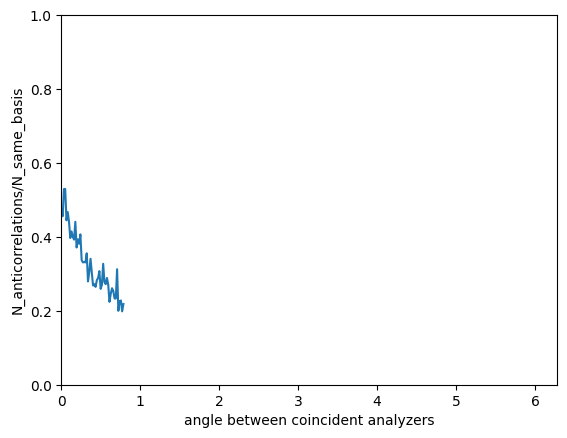

In [124]:
states = int(1e3)
execs = int(5e1)
main(n_states=states,n_execs=execs)